In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa
import xarray as xr
import rasterio
import psutil
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

#### TODO
- test kernels, including pyddem
- score kernels with loocv

In [3]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    ip_addres='http://sunhado.ce.washington.edu',
                                    port=':8787')


Dask dashboard at: http://sunhado.ce.washington.edu:8787/status
Workers: 31
Threads per worker: 1 



## Load data from S3

In [4]:
bucket = 'petrichor'
aws_server_url = 's3.us-west-2.amazonaws.com'
site = 'rainier'
crs = rasterio.crs.CRS.from_epsg(4326)

zarr_url = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                  aws_server_url = aws_server_url,
                                  folder = gtsa.io.Path(site, 'stack_with_EE').as_posix(),
                                  extension= 'zarr')[0]

rgi_url = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                  aws_server_url = aws_server_url,
                                  folder = 'rgi',
                                  extension= 'geojson')[0]


### Lazy load dataset

In [5]:
ds = xr.open_dataset(zarr_url,chunks='auto',engine='zarr')
ds = ds.rio.write_crs(crs)

### Load RGI glaciers within bounds of dataset

In [6]:
rgi_gdf = gpd.read_file(rgi_url, bbox = ds.rio.bounds())

### Load DEM uncertainties

In [7]:
dem_nmad_url = gtsa.io.parse_urls_from_S3_bucket(bucket,
                                  aws_server_url = aws_server_url,
                                  folder = gtsa.io.Path(site, 'dems').as_posix(),
                                  extension= 'csv')[0]

df_nmad = pd.read_csv(dem_nmad_url)
alphas = df_nmad['nmad'].values

### Get single glacier for testing

In [8]:
glacier_gdf = rgi_gdf[rgi_gdf['Name'].str.contains('Nisqually')]

### Subset dataset to bounds of single glacier

In [9]:
xmin, ymin, xmax, ymax = glacier_gdf.total_bounds
glacier_ds = ds.sel(x=slice(xmin, xmax), y=slice(ymax,ymin))

### Compute per-pixel nmad and count

In [10]:
count_da = gtsa.temporal.xr_dask_count(glacier_ds)
nmad_da = gtsa.temporal.xr_dask_nmad(glacier_ds)

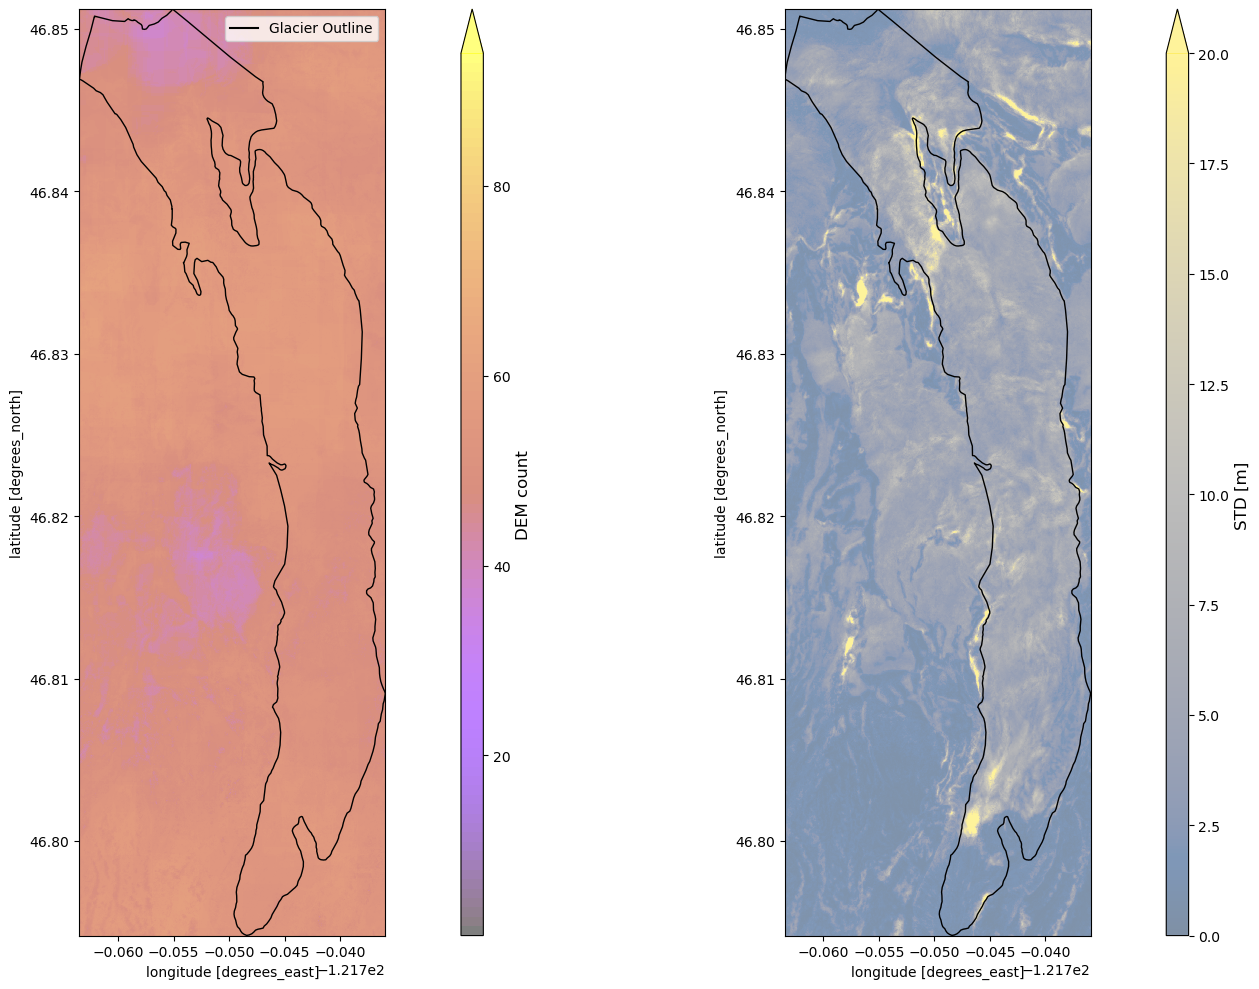

In [11]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                        nmad_da,
                                        glacier_gdf,
                                        count_vmax=len(glacier_ds.time),
                                        alpha=0.5)

### Get OGGM centerline and extract sample points

In [12]:
rgi_id = glacier_gdf['RGIId'].values[0]
flowline_gdf = gtsa.utils.OGGM_get_centerline(rgi_id, crs = ds.rio.crs)

In [13]:
longest_segment = flowline_gdf[flowline_gdf['LE_SEGMENT'] == flowline_gdf['LE_SEGMENT'].max()]
points = gtsa.utils.extract_linestring_coords(longest_segment['geometry'].iloc[0])

In [14]:
# select every nth point
step = 16
points = [points[0][::step], points[1][::step]]
print(len(points[0]))

10


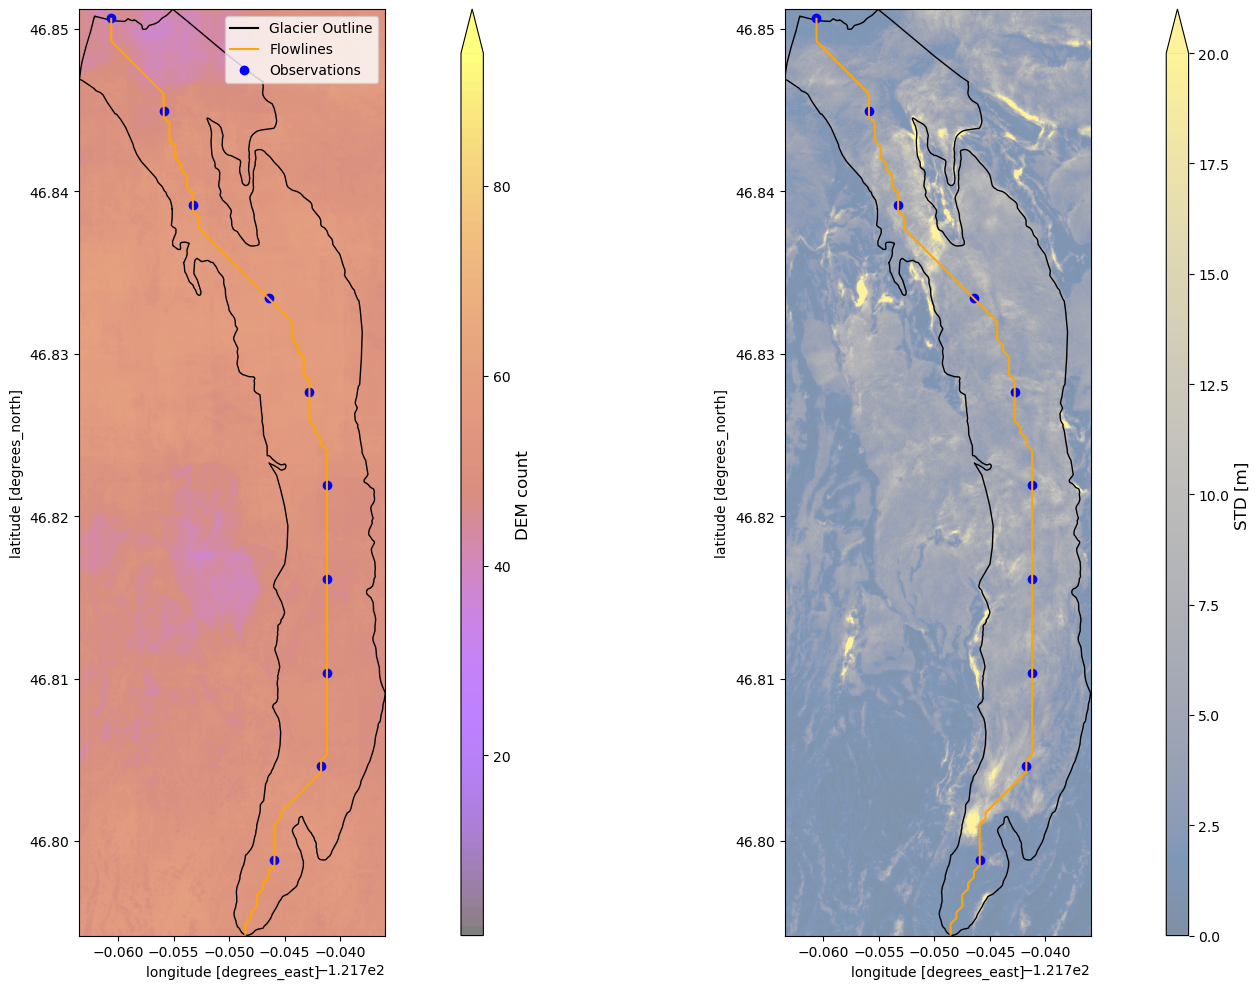

In [15]:
gtsa.plotting.xr_plot_count_std_glacier(count_da,
                                        nmad_da,
                                   glacier_gdf,
                                   longest_segment,
                                   points=points,
                                   alpha=0.5,
                                   count_vmax=len(glacier_ds.time))

### Sample time series at points

In [16]:
date_times = [pd.to_datetime(x) for x in ds['time'].values]
dec_year_dates = np.array([gtsa.utils.date_time_to_decyear(i) for i in date_times])

In [17]:
x_coords = points[0]
y_coords = points[1]

tmp = []
for i, v in enumerate(x_coords):
    sub = glacier_ds['band1'].sel(x=x_coords[i], 
                                  y=y_coords[i], 
                                  method="nearest")
    
    tmp.append(sub.values)

### Remove nans and subtract mean

In [18]:
test_time       = []
test_data_tmp   = []
test_alphas     = []
for i in tmp:
    mask = np.isfinite(i)
    test_data_tmp.append(i[mask])
    test_time.append(dec_year_dates[mask])
    test_alphas.append(alphas[mask])

In [19]:
test_data = test_data_tmp

In [20]:
test_data = []
for i in test_data_tmp:
    j = i - i.mean()
    test_data.append(j)

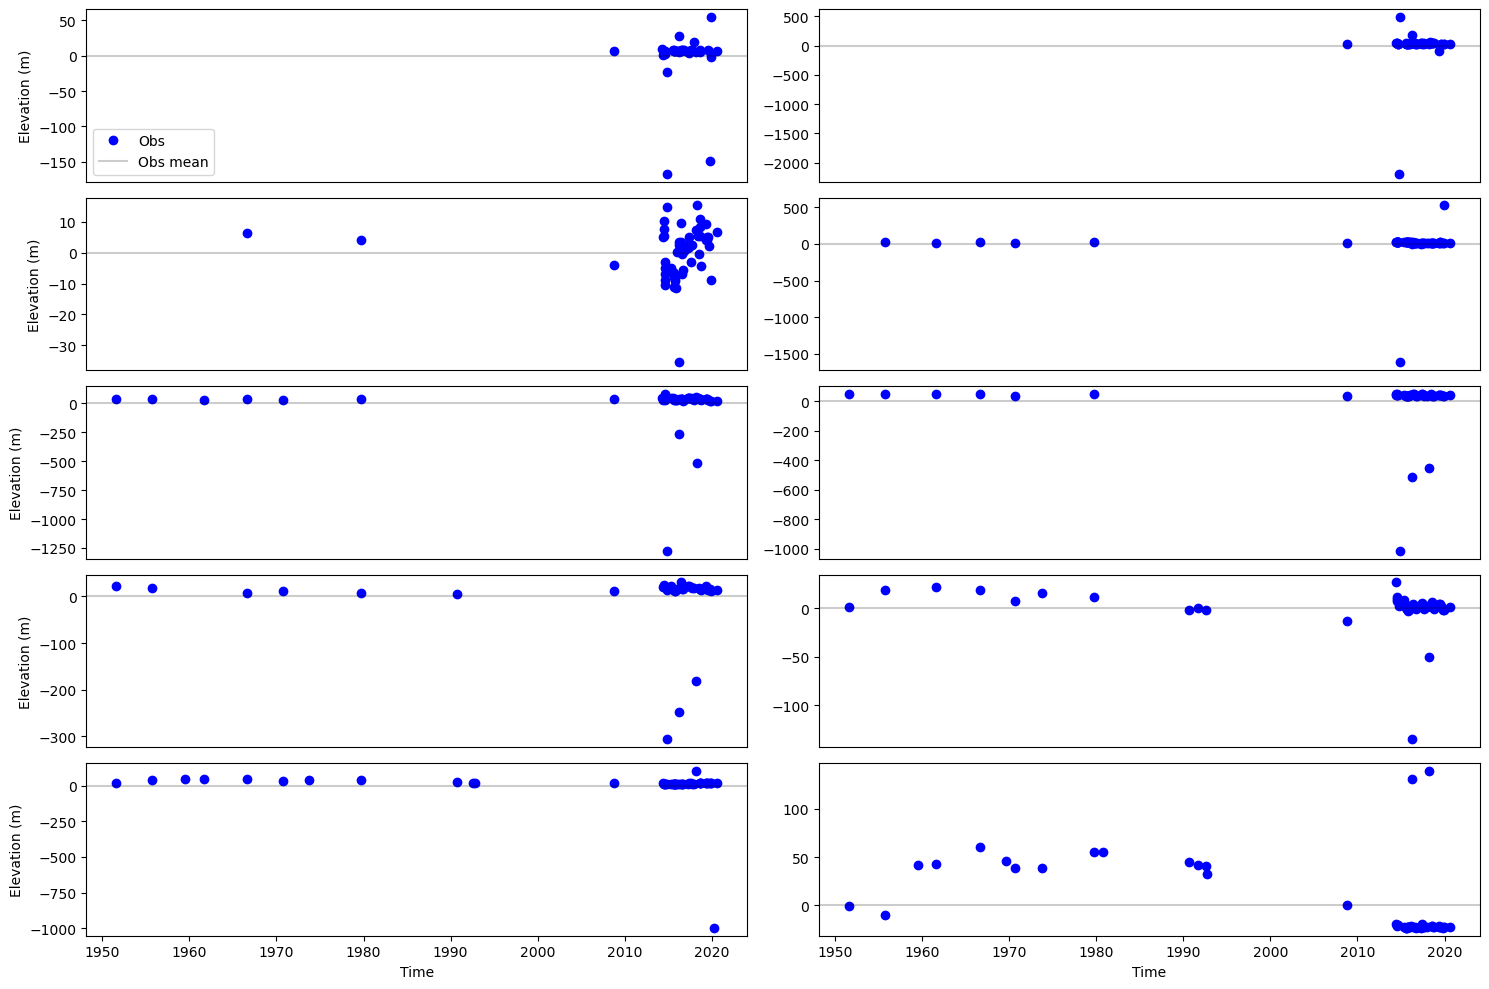

In [21]:
gtsa.plotting.plot_time_series_gallery(test_time,
                                       test_data, 
                                       sharey=False)

### Create prediction time series

In [22]:
prediction_time_series = gtsa.temporal.create_prediction_timeseries(start_date = '1950-01-01',
                                               end_date = '2023-01-01',
                                               dt ='M')

### Filter outliers and predict

In [23]:
test_data_filtered   = []
test_time_filtered   = []
test_alphas_filtered = []
test_data_masked   = []
test_time_masked   = []
test_alphas_masked = []
masks = []

predictions = []
std_predictions = []

for i,v in enumerate(test_time):
    time_array = test_time[i]
    data_array = test_data[i]
    alpha_array = test_alphas[i]
    
#     mask = gtsa.temporal.mask_outliers_rate_of_change(time_array,
#                                                       data_array, 
#                                                       threshold = 100)
    
    mask = gtsa.temporal.mask_outliers_gaussian_process(time_array, 
                                                        data_array, 
                                                        alpha_array)

        
    masks.append(mask)
    test_data_filtered.append(test_data[i][mask])
    test_time_filtered.append(test_time[i][mask])
    test_alphas_filtered.append(test_alphas[i][mask])
    test_data_masked.append(test_data[i][~mask])
    test_time_masked.append(test_time[i][~mask])
    test_alphas_masked.append(test_alphas[i][~mask])
    
    
    # fit prediction kernel with seasonal trend to filtered data and predict for full time series
    kernel = gtsa.temporal.GPR_kernel_projection_seasonal()    
    gaussian_process_model = gtsa.temporal.GPR_model(test_time_filtered[i], 
                                                test_data_filtered[i], 
                                                kernel, 
                                                alpha=test_alphas_filtered[i])

    mean_prediction, std_prediction = gtsa.temporal.GPR_predict(gaussian_process_model, 
                                                   prediction_time_series)
    
    predictions.append(mean_prediction)
    std_predictions.append(std_prediction)
    
GPR_df = pd.DataFrame(predictions).T
GPR_df.index = prediction_time_series

GPR_std_df = pd.DataFrame(std_predictions).T
GPR_std_df.index = prediction_time_series

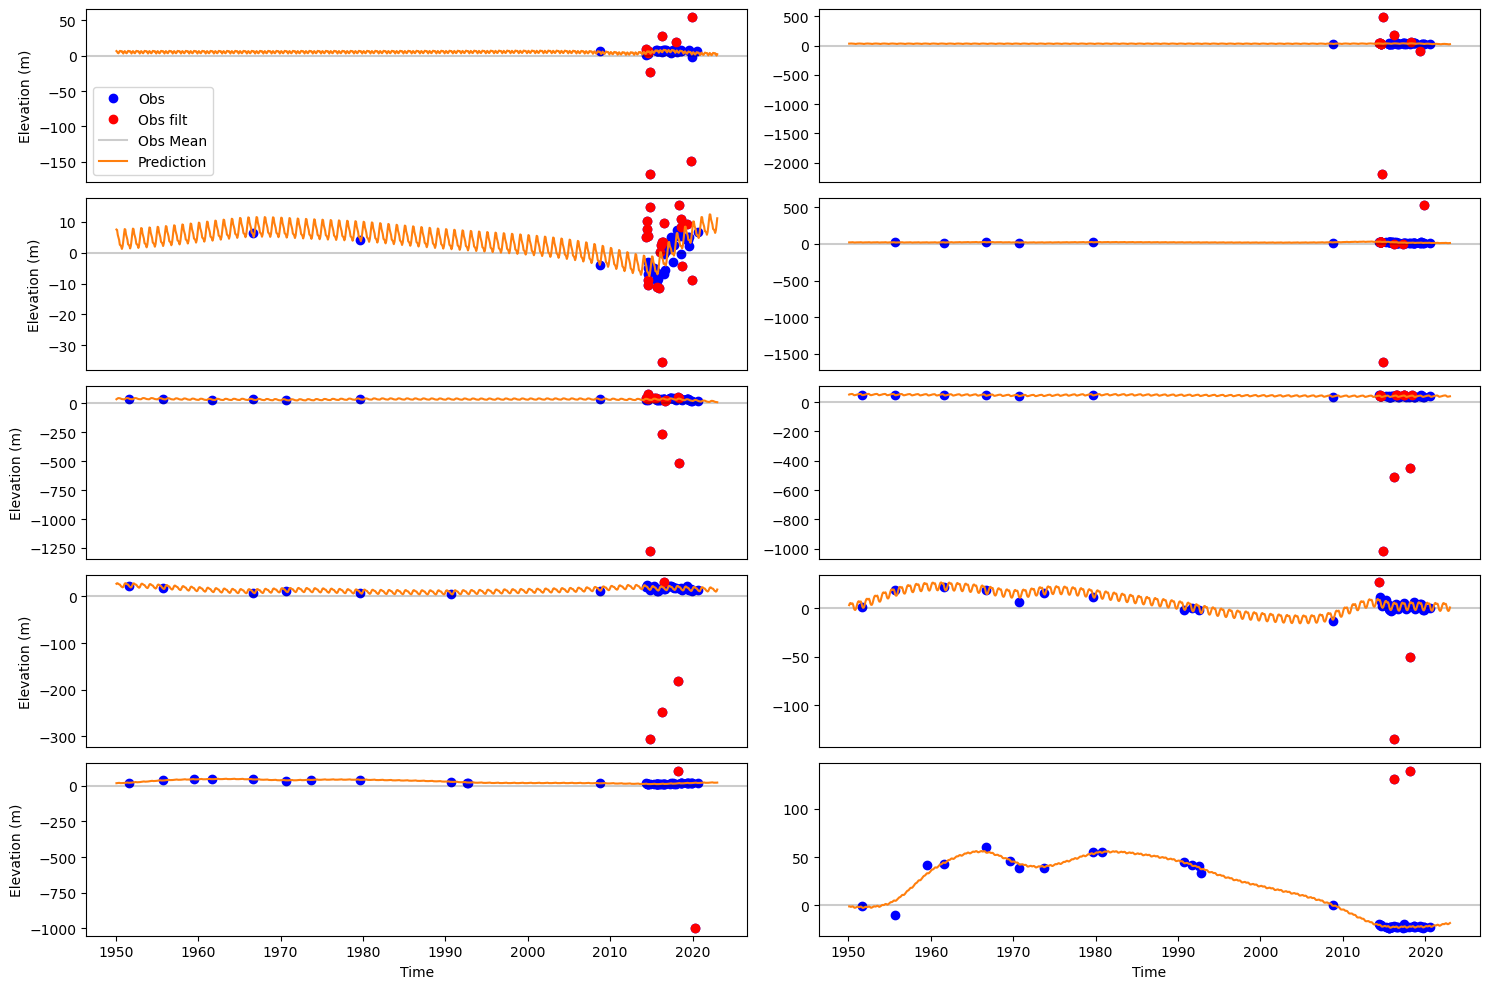

In [24]:
gtsa.plotting.plot_time_series_gallery(test_time,
                                       test_data,
                                       masked_x_values=test_time_masked,
                                       masked_y_values=test_data_masked,
                                       predictions_df_list=[GPR_df],
                                       legend_labels = ["Obs",
                                                        "Obs filt",
                                                        "Obs Mean",
                                                        "Prediction"], 
                                       sharey=False)

### Examine single time series

In [25]:
idx = 0
tt = [test_time_filtered[idx],]
td = [test_data_filtered[idx],]
ftt = [test_time_masked[idx],]
ftd = [test_data_masked[idx],]
gp = GPR_df.iloc[:,idx:idx+1].rename(columns={GPR_df.columns[idx]: 0})
st = GPR_std_df.iloc[:,idx:idx+1].rename(columns={GPR_df.columns[idx]: 0})

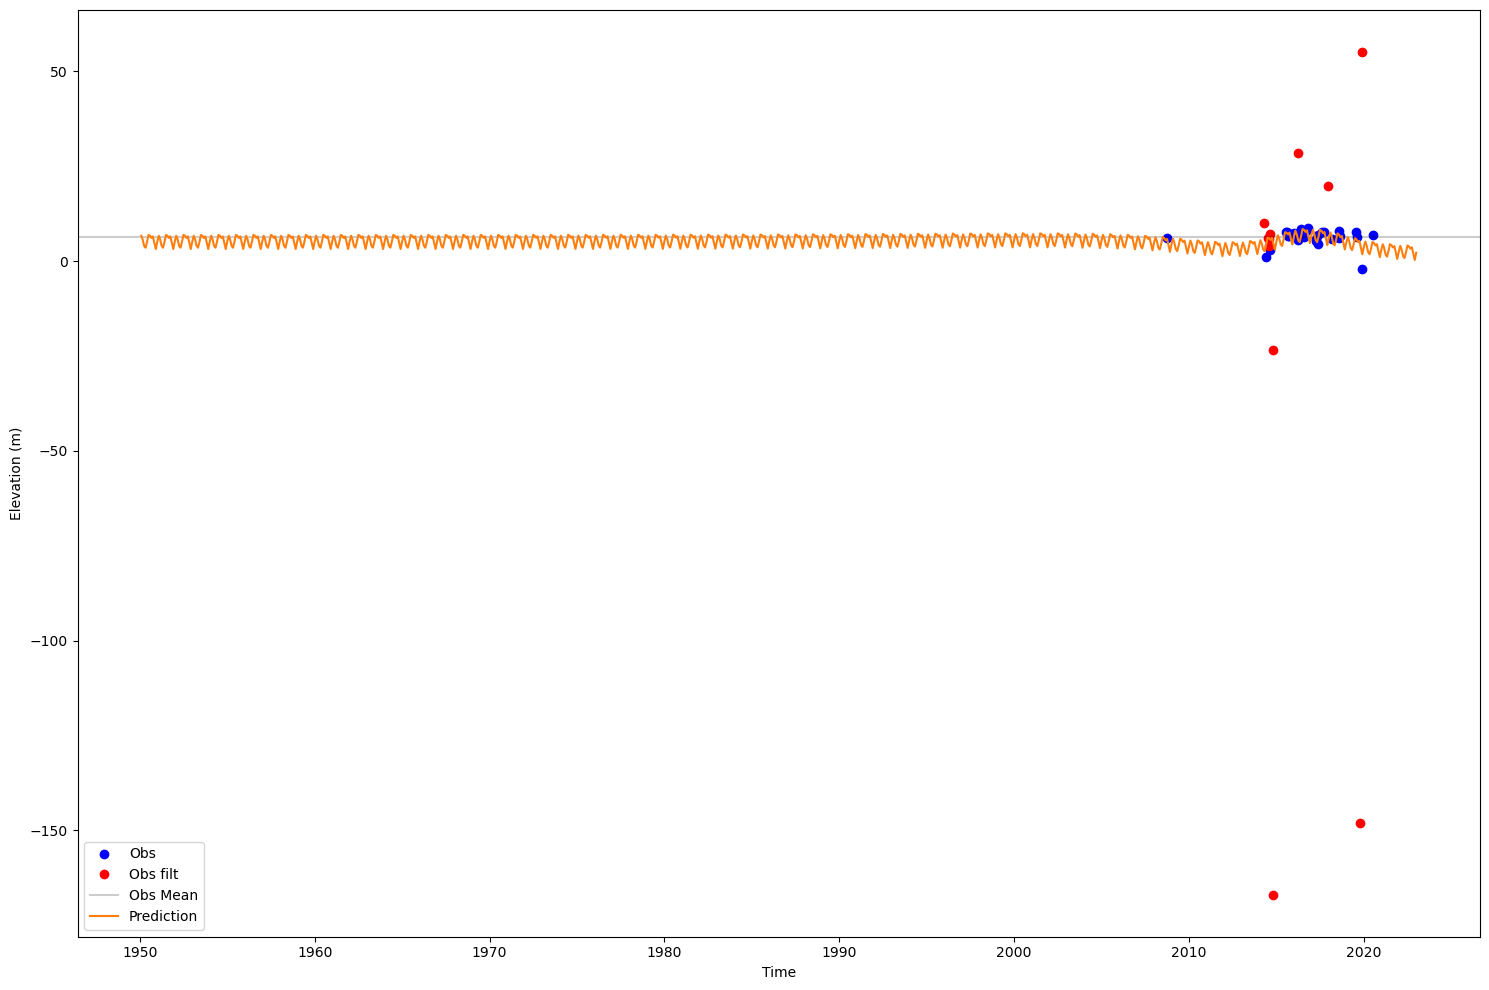

In [26]:
gtsa.plotting.plot_time_series_gallery(tt,
                                  td,
                                       ftt,
                                       ftd,
                                  predictions_df_list=[gp],
#                                   std_df_list=[st],
                                       legend_labels = ["Obs",
                                                        "Obs filt",
                                                        "Obs Mean",
                                                        "Prediction",
                                                        "Prediction STD"], 
                                  sharey=False)